# Import Libraries

In [1]:
import os
import time
import torch
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from torchtext import data, datasets
from torchtext.vocab import GloVe
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, LSTM, Embedding, Bidirectional, GRU, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

%matplotlib inline

In [2]:
# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data Exploration

In [3]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True)
# For multi-class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

# Data Preprocessing

In [4]:
# Split training data into train and validation sets
train_data, valid_data = train_data.split(split_ratio=0.8)

print("Train size (after splitting):", len(train_data.examples))
print("Validation size:", len(valid_data.examples))
print("Test size:", len(test_data.examples))

Train size (after splitting): 4362
Validation size: 1090
Test size: 500


In [5]:
# Tokenizer and Vocabulary with GloVe
TEXT.build_vocab(train_data, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

INFO:torchtext.vocab:Loading vectors from .vector_cache\glove.6B.100d.txt.pt


In [6]:
# Prepare embedding matrix with OOV strategies
embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Subword parameters
ngram_min = 3
ngram_max = 6

# Count word frequency in training data
word_counter = Counter()
for example in train_data:
    word_counter.update([w.lower().strip(string.punctuation) for w in example.text])

# Threshold to consider a word “frequent” (adjustable)
freq_threshold = 3

# <unk> vector
unk_vector = torch.zeros(embedding_dim)

# Counters
subword_count = 0
random_count = 0
unk_count = 0

def get_subwords(word, n_min=3, n_max=6):
    word = f"<{word.lower()}>"
    subwords = []
    for n in range(n_min, n_max+1):
        subwords += [word[i:i+n] for i in range(len(word)-n+1)]
    return subwords

def get_word_vector(word):
    global subword_count, random_count, unk_count
    w_clean = word.lower().strip(string.punctuation)
    
    if w_clean in glove_vocab:
        return vectors[vocab.stoi[w_clean]]
    
    # Subword averaging
    subwords = get_subwords(w_clean, ngram_min, ngram_max)
    subword_vecs = [vectors[vocab.stoi[sg]] for sg in subwords if sg in glove_vocab]
    if subword_vecs:
        subword_count += 1
        return torch.stack(subword_vecs).mean(0)
    
    # Random vector for frequent OOVs
    if word_counter[w_clean] >= freq_threshold:
        random_count += 1
        return torch.randn(embedding_dim)
    
    # <unk> for rare OOVs
    unk_count += 1
    return unk_vector

# Build embedding matrix
embedding_matrix = {}
for example in train_data:
    for w in example.text:
        if w not in embedding_matrix:
            embedding_matrix[w] = get_word_vector(w)

In [7]:
# Convert torchtext Dataset -> raw texts, labels
def ds_to_texts_labels(ds):
    texts, labels = [], []
    for ex in ds.examples:
        t = ex.text
        if isinstance(t, list):
            t = " ".join(t)
        texts.append(t)
        labels.append(ex.label)
    return texts, labels

train_texts, train_labels = ds_to_texts_labels(train_data)
valid_texts, valid_labels = ds_to_texts_labels(valid_data)
test_texts,  test_labels  = ds_to_texts_labels(test_data)

In [8]:
# Tokenizer + sequences
MAX_VOCAB = globals().get("MAX_VOCAB", 20000)
MAX_LEN   = globals().get("MAX_LEN", 50)

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(train_texts)

X_train = pad_sequences(tok.texts_to_sequences(train_texts), maxlen=MAX_LEN, padding="post", truncating="post")
X_valid = pad_sequences(tok.texts_to_sequences(valid_texts), maxlen=MAX_LEN, padding="post", truncating="post")
X_test  = pad_sequences(tok.texts_to_sequences(test_texts),  maxlen=MAX_LEN, padding="post", truncating="post")

In [9]:
# Labels -> one-hot
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(train_labels))
y_valid = to_categorical(le.transform(valid_labels))
y_test  = to_categorical(le.transform(test_labels))
nclasses = y_train.shape[1]

In [10]:
# Build embedding_weights aligned to tok.word_index
vocab_size = min(MAX_VOCAB, len(tok.word_index) + 1)
embedding_dim = globals().get("embedding_dim", 100)

embedding_weights = np.zeros((vocab_size, embedding_dim), dtype="float32")

for w, i in tok.word_index.items():
    if i >= vocab_size:
        continue
    vec = None
    # Token vector from embedding_matrix
    if w in embedding_matrix:
        vec = embedding_matrix[w]
    else:
        # Try normalized lookup against torchtext vocab
        w_clean = w.lower().strip(string.punctuation)
        if hasattr(TEXT, "vocab") and w_clean in TEXT.vocab.stoi:
            vec = TEXT.vocab.vectors[TEXT.vocab.stoi[w_clean]]
        else:
            # Use OOV function (returns torch tensor)
            try:
                vec = get_word_vector(w)
            except Exception:
                vec = None

    # Convert to numpy if torch tensor
    if isinstance(vec, torch.Tensor):
        embedding_weights[i] = vec.cpu().numpy()
    elif isinstance(vec, np.ndarray):
        embedding_weights[i] = vec

In [11]:
# Ensure padding index 0 is zeros
embedding_weights[0] = np.zeros(embedding_dim, dtype=np.float32)

# Ensure OOV token has non-zero vector if possible
oov_idx = tok.word_index.get(tok.oov_token)
if oov_idx is not None and oov_idx < vocab_size:
    known = embedding_weights[(embedding_weights != 0).any(axis=1)]
    if known.size:
        embedding_weights[oov_idx] = known.mean(axis=0)

print("X_train.shape, X_valid.shape, X_test.shape:", X_train.shape, X_valid.shape, X_test.shape)
print("y_train.shape, nclasses, vocab_size:", y_train.shape, nclasses, vocab_size)

X_train.shape, X_valid.shape, X_test.shape: (4362, 50) (1090, 50) (500, 50)
y_train.shape, nclasses, vocab_size: (4362, 6) 6 7415


# BiLSTM Model
### Building and Training the Model

In [12]:
# 5) Define and compile BiLSTM model (make sure EMBEDDING_DIM matches 100)
def build_bilstm(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# model = build_bilstm(nclasses, vocab_size, EMB_DIM, MAX_LEN, emb_matrix)
model = build_bilstm(nclasses, vocab_size, embedding_dim, MAX_LEN, embedding_weights)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
# 6) Train the model with early stopping
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64, callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 630ms/step - accuracy: 0.4537 - loss: 1.3422 - val_accuracy: 0.6743 - val_loss: 0.9070
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 585ms/step - accuracy: 0.7529 - loss: 0.7082 - val_accuracy: 0.7917 - val_loss: 0.6049
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 603ms/step - accuracy: 0.8343 - loss: 0.4965 - val_accuracy: 0.7936 - val_loss: 0.5835
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - accuracy: 0.8790 - loss: 0.3623 - val_accuracy: 0.8101 - val_loss: 0.5577
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 573ms/step - accuracy: 0.9113 - loss: 0.2816 - val_accuracy: 0.8101 - val_loss: 0.6068
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 570ms/step - accuracy: 0.9237 - loss: 0.2380 - val_accuracy: 0.7954 - val_loss: 0.6520
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 592ms/step - accuracy: 0.9427 - loss: 0.1771 - val_accuracy: 0.8202 - val_loss: 0.6305
Training time: 301.68428921699524


In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 100)        │       742,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 50, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 50, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,178,436 (12.12 MB)

 Trainable params: 1,059,478 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,118,958 (8.08 MB)

In [17]:
# 7) Plot accuracy and loss curves
def plot_history(history):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Handle possible key names
    acc = h.get("accuracy", h.get("acc"))
    val_acc = h.get("val_accuracy", h.get("val_acc"))
    loss = h.get("loss")
    val_loss = h.get("val_loss")

    plt.figure(figsize=(10, 12))

    # Accuracy
    plt.subplot(2, 1, 1)
    if acc is not None:
        plt.plot(epochs, acc, label="train")
    if val_acc is not None:
        plt.plot(epochs, val_acc, label="val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(2, 1, 2)
    if loss is not None:
        plt.plot(epochs, loss, label="train")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

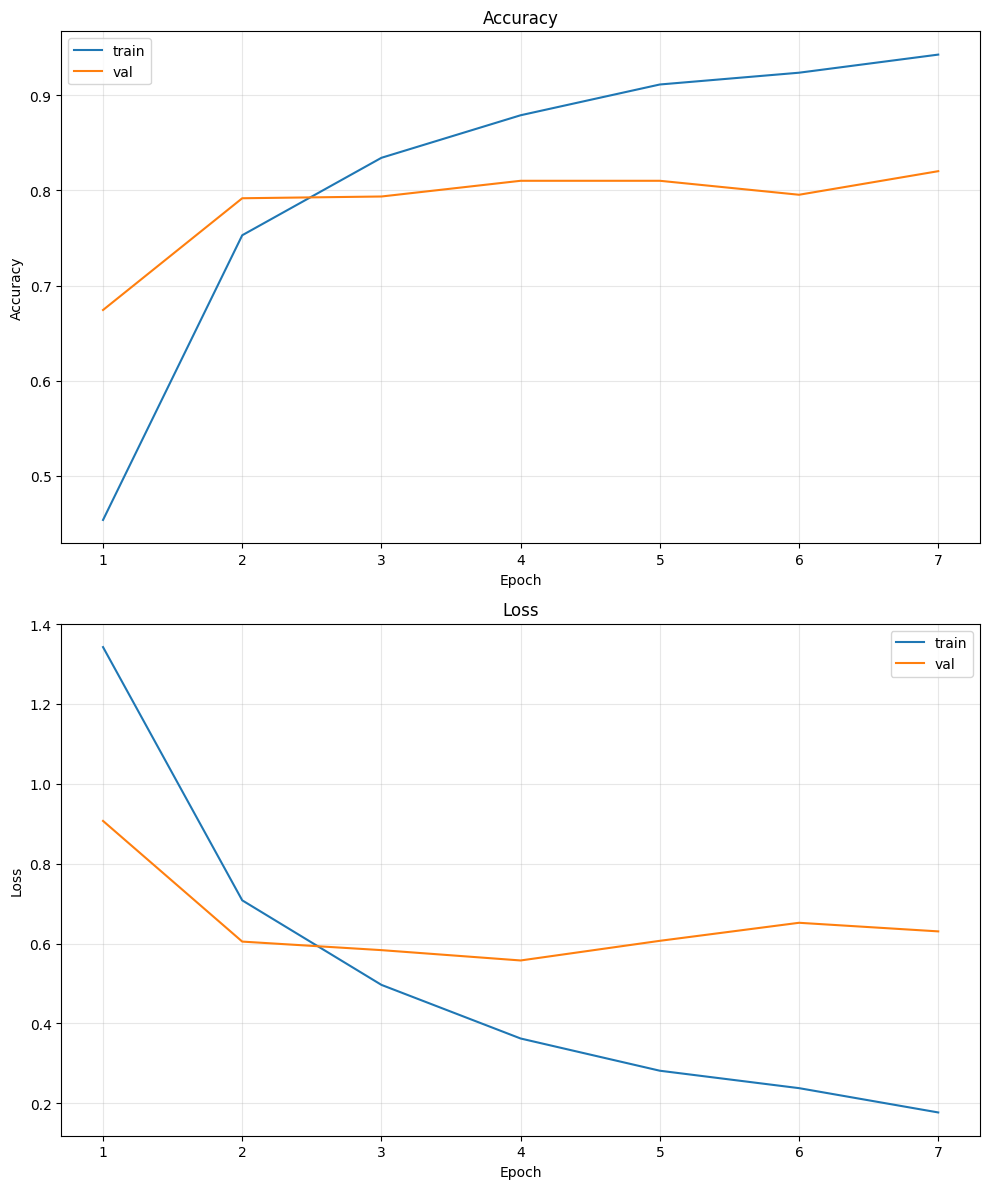

In [ ]:
plot_history(history)

### Inference on Test Set

In [40]:
# 8) Evaluate on test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step
Test accuracy: 0.816
              precision    recall  f1-score   support

        ABBR       1.00      0.56      0.71         9
        DESC       0.69      0.99      0.81       138
        ENTY       0.83      0.51      0.63        94
         HUM       0.95      0.89      0.92        65
         LOC       0.96      0.81      0.88        81
         NUM       0.86      0.84      0.85       113

    accuracy                           0.82       500
   macro avg       0.88      0.77      0.80       500
weighted avg       0.84      0.82      0.81       500



Topic-wise accuracy on test set:
ABBR: 0.5556 (n=9)
DESC: 0.9855 (n=138)
ENTY: 0.5106 (n=94)
HUM: 0.8923 (n=65)
LOC: 0.8148 (n=81)
NUM: 0.8407 (n=113)


<Figure size 1000x800 with 0 Axes>

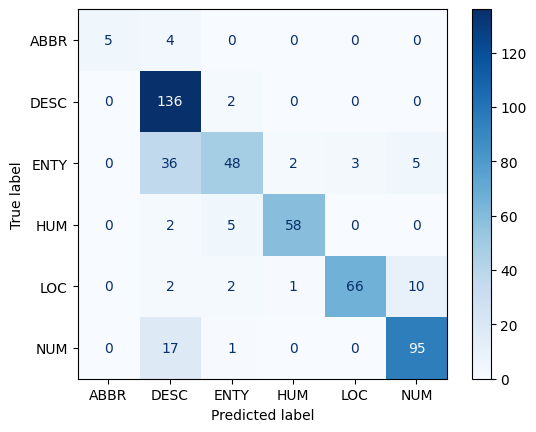

In [41]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [43]:
# Save weights
model.save_weights('bilstm_model.weights.h5')

### Regularization: Adversarial Training

In [13]:
class AdversarialTrainer(tf.keras.Model):
    def __init__(self, base_model, epsilon=0.5, alpha=0.5, mask_pad=True):
        super().__init__()
        self.base_model = base_model
        self.embed = base_model.layers[0]           # Embedding layer
        self.rest = base_model.layers[1:]           # The rest of the network
        self.epsilon = tf.constant(epsilon, dtype=tf.float32)
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.mask_pad = mask_pad

    def call(self, x, training=False):
        return self.base_model(x, training=training)

    def _forward_from_embeddings(self, emb, training=True):
        h = emb
        for layer in self.rest:
            h = layer(h, training=training)
        return h

    def train_step(self, data):
        x, y = data

        # 1) Compute perturbation η with a short tape (no weight updates)
        with tf.GradientTape() as tape_eta:
            emb = self.embed(x)                 # (B, T, D)
            tape_eta.watch(emb)
            y_pred_clean = self._forward_from_embeddings(emb, training=True)
            loss_clean = self.compiled_loss(y, y_pred_clean)  # no reg losses here

        grad = tape_eta.gradient(loss_clean, emb)             # outside the context
        norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(grad), axis=[1,2], keepdims=True), 1e-12))
        eta = self.epsilon * grad / norm

        if self.mask_pad:
            pad_mask = tf.cast(tf.not_equal(x, 0), emb.dtype)  # (B, T)
            pad_mask = tf.expand_dims(pad_mask, -1)            # (B, T, 1)
            eta = eta * pad_mask

        eta = tf.stop_gradient(eta)  # do not backprop through η construction

        # 2) Final loss and weight update with a fresh tape
        with tf.GradientTape() as tape:
            emb2 = self.embed(x)
            y_pred_clean2 = self._forward_from_embeddings(emb2, training=True)
            loss_clean2 = self.compiled_loss(y, y_pred_clean2, regularization_losses=self.base_model.losses)

            y_pred_adv = self._forward_from_embeddings(emb2 + eta, training=True)
            loss_adv = self.compiled_loss(y, y_pred_adv)

            loss = self.alpha * loss_clean2 + (1.0 - self.alpha) * loss_adv

        grads = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.base_model.trainable_variables))

        for metric in self.metrics:
            metric.update_state(y, y_pred_clean2)

        results = {m.name: m.result() for m in self.metrics}
        results["loss"] = loss
        return results

In [45]:
# Load model weights
model.load_weights('bilstm_model.weights.h5')

In [ ]:
# Usage: Wrap your built model
epsilon = 0.5   # try 0.1–2.0; tune per validation
alpha   = 0.5   # 0.5 means equal weight clean/adv
adv_model = AdversarialTrainer(model, epsilon=epsilon, alpha=alpha, mask_pad=True)

# Recompile (reuse your optimizer/loss/metrics)
opt = Adam(learning_rate=1e-3)
adv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train with the same data/callbacks
history = adv_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64,
    callbacks=[es], verbose=1
)

Epoch 1/10


c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\backend\tensorflow\trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.4434 - loss: 0.7678 - val_accuracy: 0.5706 - val_loss: 1.0542
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.6891 - loss: 0.5276 - val_accuracy: 0.7450 - val_loss: 0.6719
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.8063 - loss: 0.3970 - val_accuracy: 0.7982 - val_loss: 0.5233
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.8657 - loss: 0.1803 - val_accuracy: 0.8110 - val_loss: 0.5022
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9081 - loss: 0.0358 - val_accuracy: 0.8385 - val_loss: 0.4724
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9464 - loss: 0.0271 - val_accuracy: 0.8486 - val_loss: 0.4500
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9649 - loss: 0.0163 - val_accuracy: 0.8661 - val_loss: 0.4527
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.9771 - loss: 0.0088 - val_accuracy: 0.8633 - val_loss: 0.

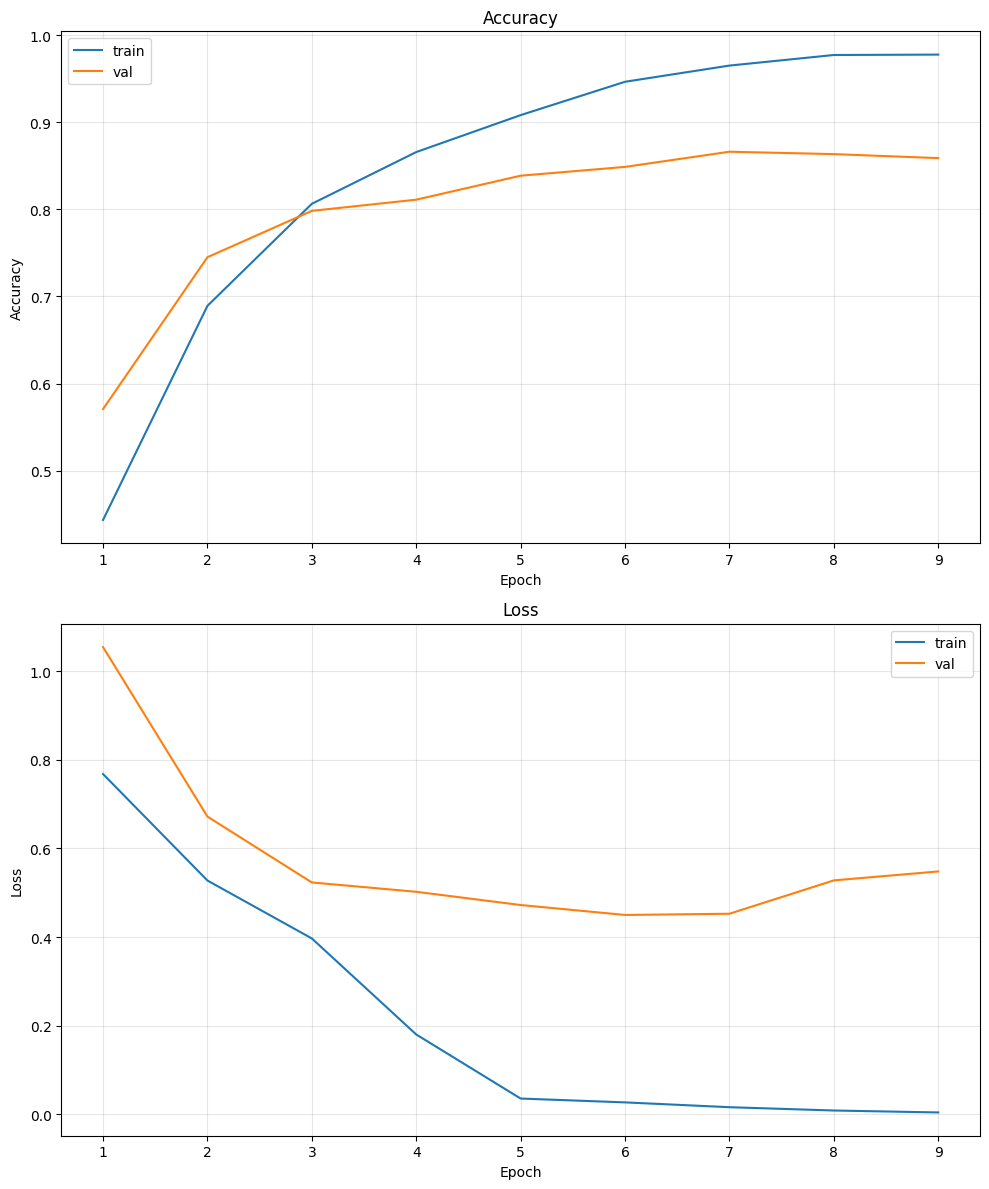

In [18]:
plot_history(history)

In [19]:
# 8) Evaluate on test set
y_pred = adv_model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step
Test accuracy: 0.896
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.86      0.99      0.92       138
        ENTY       0.93      0.67      0.78        94
         HUM       0.85      0.97      0.91        65
         LOC       0.86      0.99      0.92        81
         NUM       0.99      0.88      0.93       113

    accuracy                           0.90       500
   macro avg       0.91      0.88      0.89       500
weighted avg       0.90      0.90      0.89       500



Topic-wise accuracy on test set:
ABBR: 0.7778 (n=9)
DESC: 0.9855 (n=138)
ENTY: 0.6702 (n=94)
HUM: 0.9692 (n=65)
LOC: 0.9877 (n=81)
NUM: 0.8761 (n=113)


<Figure size 1000x800 with 0 Axes>

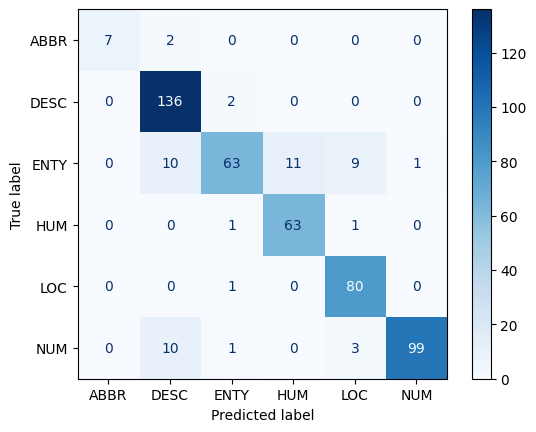

In [20]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [21]:
# Save weights
adv_model.save_weights('bilstm_adv_model.weights.h5')

# BiGRU Model
### Building and Training the Model

In [22]:
# 9) Define and compile BiGRU model (make sure EMBEDDING_DIM matches 100)
def build_bigru(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# model = build_bigru(nclasses, vocab_size, EMB_DIM, MAX_LEN, emb_matrix)
model = build_bigru(nclasses, vocab_size, embedding_dim, MAX_LEN, embedding_weights)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [56]:
# 10) Train the model with early stopping
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64, callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - accuracy: 0.5362 - loss: 1.1669 - val_accuracy: 0.6780 - val_loss: 0.8292
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 430ms/step - accuracy: 0.7877 - loss: 0.5998 - val_accuracy: 0.8101 - val_loss: 0.5326
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 416ms/step - accuracy: 0.8569 - loss: 0.4136 - val_accuracy: 0.8028 - val_loss: 0.5530
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 410ms/step - accuracy: 0.9039 - loss: 0.2903 - val_accuracy: 0.8385 - val_loss: 0.4864
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - accuracy: 0.9397 - loss: 0.1922 - val_accuracy: 0.8550 - val_loss: 0.5021
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 400ms/step - accuracy: 0.9626 - loss: 0.1276 - val_accuracy: 0.8468 - val_loss: 0.5464
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 398ms/step - accuracy: 0.9732 - loss: 0.0869 - val_accuracy: 0.8486 - val_loss: 0.6170
Training time: 217.53471565246582


In [57]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 100)        │       742,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 50, 128)        │        63,744 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 50, 128)        │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 128)            │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,970,308 (11.33 MB)

 Trainable params: 990,102 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,980,206 (7.55 MB)

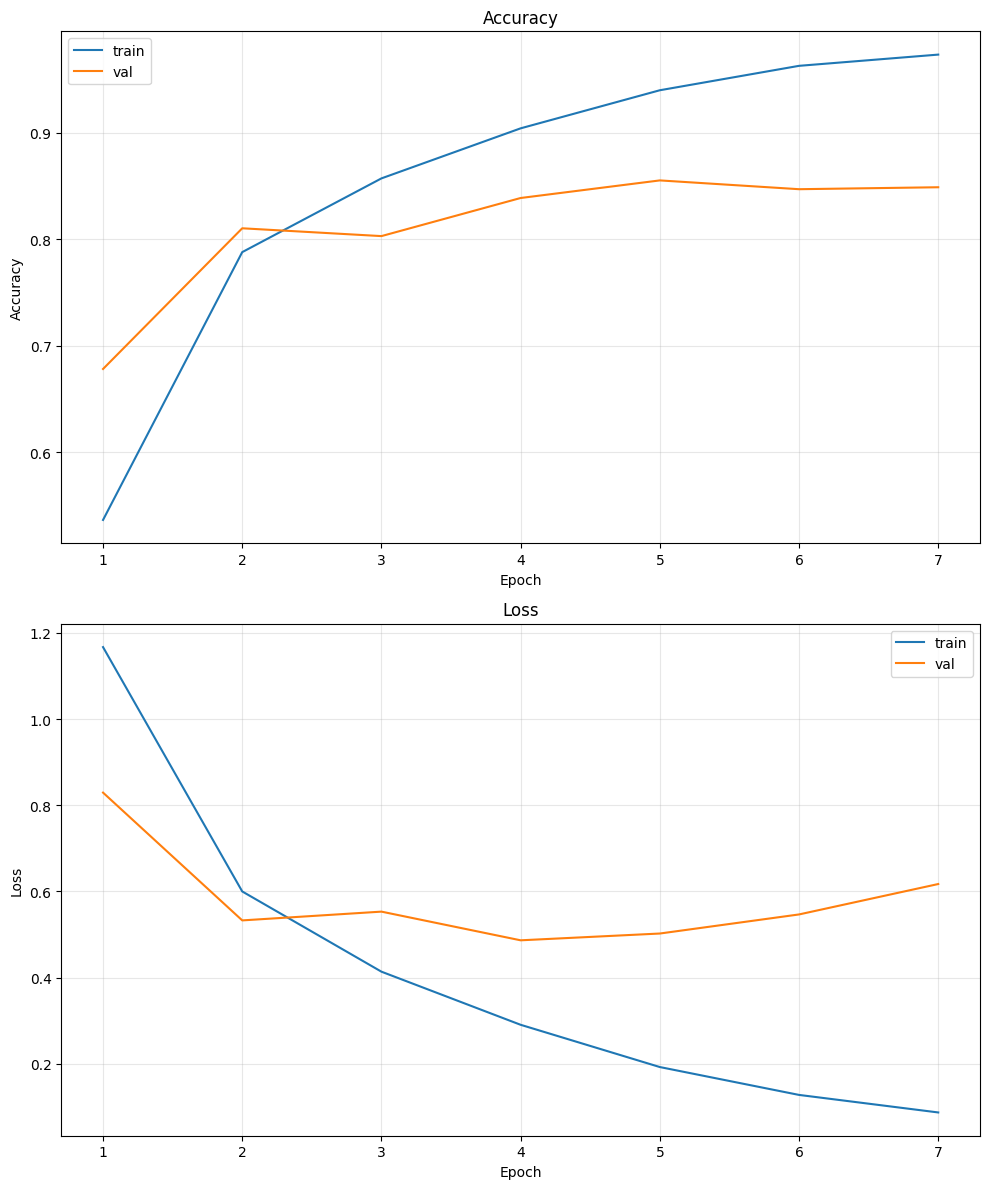

In [58]:
# 11) Plot accuracy and loss curves
plot_history(history)

### Inference on Test Set

In [59]:
# 12) Evaluate on test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step
Test accuracy: 0.846
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.74      0.97      0.84       138
        ENTY       0.88      0.62      0.72        94
         HUM       0.89      0.89      0.89        65
         LOC       0.84      0.94      0.89        81
         NUM       0.99      0.80      0.88       113

    accuracy                           0.85       500
   macro avg       0.89      0.83      0.85       500
weighted avg       0.86      0.85      0.84       500



Topic-wise accuracy on test set:
ABBR: 0.7778 (n=9)
DESC: 0.9710 (n=138)
ENTY: 0.6170 (n=94)
HUM: 0.8923 (n=65)
LOC: 0.9383 (n=81)
NUM: 0.7965 (n=113)


<Figure size 1000x800 with 0 Axes>

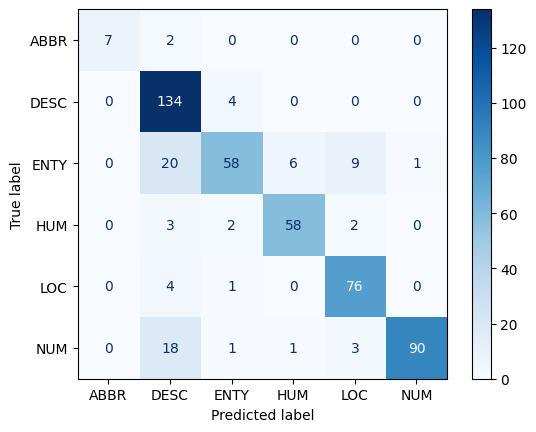

In [60]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
# Save weights
model.save_weights('bigru_model.weights.h5')

### Adversarial Training

In [ ]:
# Load weights
model.load_weights('bigru_model.weights.h5')

In [23]:
epsilon = 0.5   # try 0.1–2.0; tune per validation
alpha   = 0.5   # 0.5 means equal weight clean/adv
adv_model = AdversarialTrainer(model, epsilon=epsilon, alpha=alpha, mask_pad=True)

# Recompile (reuse your optimizer/loss/metrics)
opt = Adam(learning_rate=1e-3)
adv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train with the same data/callbacks
history = adv_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10, batch_size=64,
    callbacks=[es], verbose=1
)

Epoch 1/10


c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\backend\tensorflow\trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5394 - loss: 0.5828 - val_accuracy: 0.7303 - val_loss: 0.7610
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7785 - loss: 0.4322 - val_accuracy: 0.7927 - val_loss: 0.5673
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8498 - loss: 0.2834 - val_accuracy: 0.8211 - val_loss: 0.4850
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8936 - loss: 0.1134 - val_accuracy: 0.8294 - val_loss: 0.4578
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9319 - loss: 0.0493 - val_accuracy: 0.8385 - val_loss: 0.4498
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9567 - loss: 0.0136 - val_accuracy: 0.8560 - val_loss: 0.4181
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9674 - loss: 0.0412 - val_accuracy: 0.8523 - val_loss: 0.4914
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9778 - loss: 0.0023 - val_accuracy: 0.8633 - val_loss: 0.5021
Ep

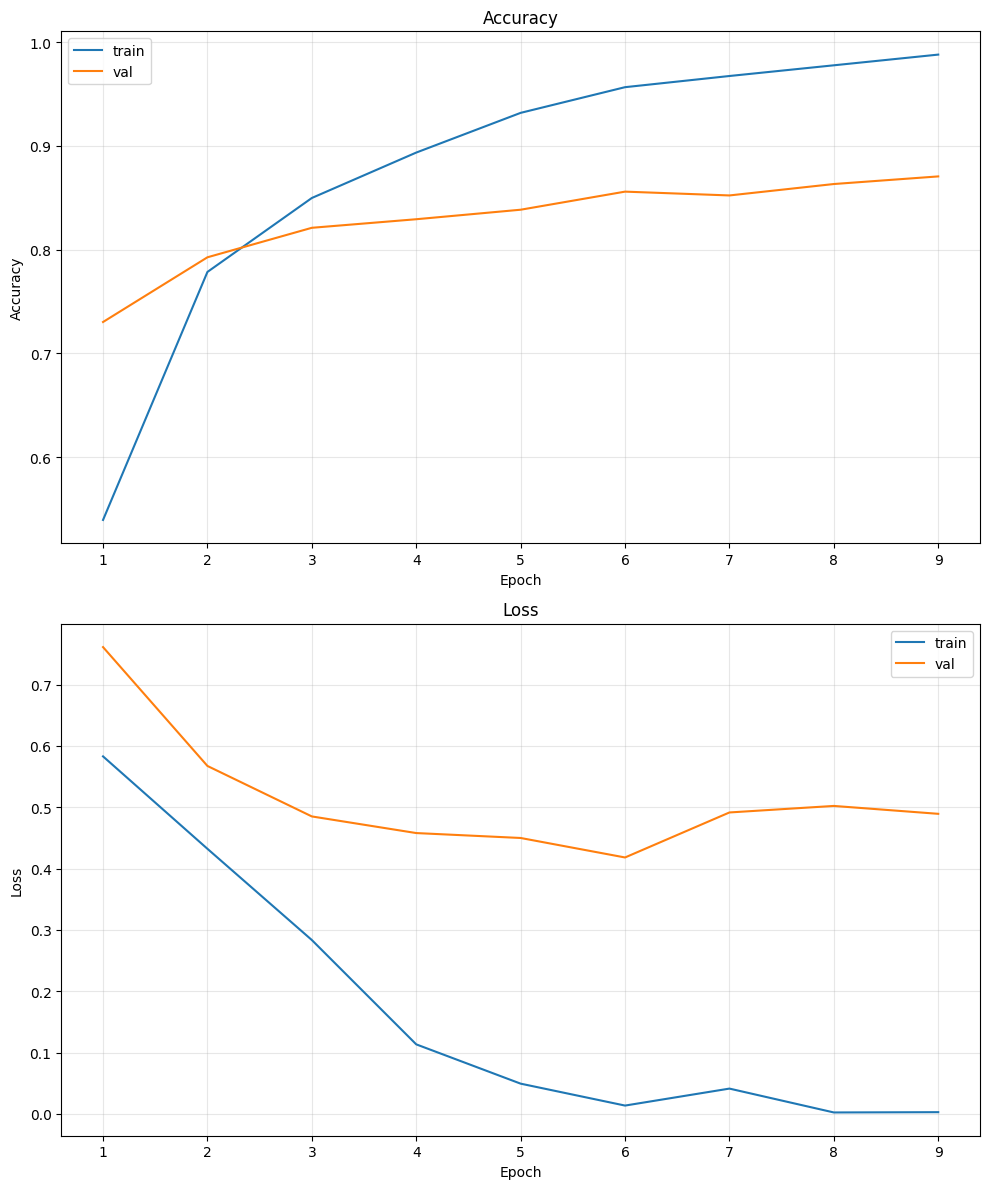

In [24]:
plot_history(history)

In [25]:
# 12) Evaluate on test set
y_pred = adv_model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step
Test accuracy: 0.892
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.83      0.99      0.90       138
        ENTY       0.94      0.69      0.80        94
         HUM       0.88      0.92      0.90        65
         LOC       0.85      0.96      0.90        81
         NUM       0.99      0.88      0.93       113

    accuracy                           0.89       500
   macro avg       0.92      0.87      0.89       500
weighted avg       0.90      0.89      0.89       500



Topic-wise accuracy on test set:
ABBR: 0.7778 (n=9)
DESC: 0.9855 (n=138)
ENTY: 0.6915 (n=94)
HUM: 0.9231 (n=65)
LOC: 0.9630 (n=81)
NUM: 0.8850 (n=113)


<Figure size 1000x800 with 0 Axes>

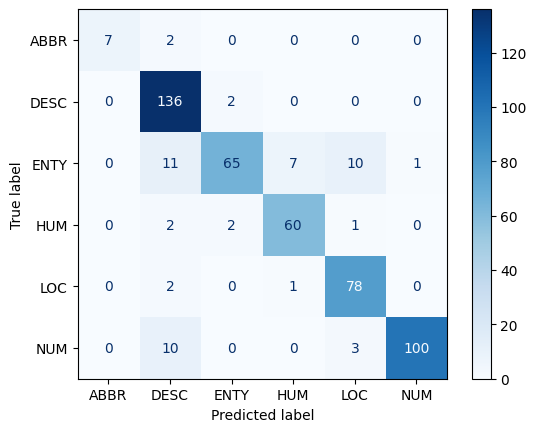

In [26]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

print("Topic-wise accuracy on test set:")

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Plot the confusion matrix
plt.figure(figsize=(10,8))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = le.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [27]:
# Save weights
adv_model.save_weights('bigru_adv_model.weights.h5')